*The prediction pipeline is based on [Comuzzi, M., Kim, S., Ko, J., Salamov, M., Cappiello, C., & Pernici, B. (2024). On the Impact of Low-Quality Activity Labels in Predictive Process Monitoring. In ICPM 2024 Workshop "ML4PM - Leveraging Machine Learning in Process Mining"].*

In this notebook, we run an LSTM-based remaining time prediction pipeline on various event logs where activity labels are ignored at various rates. More precisely, the pipeline is run after replacing a certain percentage of random activities with placeholder values. The point is to assess whether activity labels weight significantly in remaining time prediction, compared to timestamps.

# Setup

##Imports

In [ ]:
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import os
from datetime import datetime
import csv
import numpy as np
import time
import pickle
import statistics
import random

from scipy.spatial import distance as scipy_distance

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, mean_absolute_error, confusion_matrix

from keras.preprocessing.sequence import pad_sequences
from keras.models import load_model
from keras.models import Sequential
from keras.layers import LSTM, Dense, Masking
from keras.optimizers import Adam
from keras.callbacks import LearningRateScheduler, EarlyStopping, ModelCheckpoint

# Suppress warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

## Functions

In [ ]:
total_epochs = 300

def model_evaluate(df):

  start_time = time.time()

  # Group by NUMPRO and get the last event in each group
  last_events = df.groupby('NUMPRO').tail(1)

  # Get the counts of the end events
  end_event_counts = last_events['CCDOEV'].value_counts()

  # dataset
  df['DATAEV'] = pd.to_datetime(df['DATAEV'])
  df.sort_values(['NUMPRO', 'DATAEV'], inplace=True)

  # the maximum event date for each case
  df['case_end'] = df.groupby('NUMPRO')['DATAEV'].transform('max')

  # the remaining time in days for each event until the last event
  df['remaining_time'] = ((df['case_end'] - df['DATAEV']).dt.total_seconds() / 86400).astype(int)

  # Encoding event labels
  encoder = LabelEncoder()
  df['event_idx'] = encoder.fit_transform(df['CCDOEV'])

  # Normalize time differences and remaining times with separate scalers
  time_diff_scaler = MinMaxScaler()
  remaining_time_scaler = MinMaxScaler()

  # time differences in days and normalize
  df['time_diff'] = df.groupby('NUMPRO')['DATAEV'].diff().dt.total_seconds() / 86400
  df['time_diff'] = df['time_diff'].fillna(0).astype(int)  # Fill NaN with 0 and convert to int for day counts

  # sequences for LSTM
  sequences = df.groupby('NUMPRO').apply(lambda x: list(zip(x['event_idx'], x['time_diff']))) #without normalization

  max_sequence_length = 100
  sequences_padded = pad_sequences(sequences.tolist(), maxlen=max_sequence_length, padding='post', dtype='object', value=(-1, 0))

  # y values based on normalized remaining times
  y_sequences = df.groupby('NUMPRO')['remaining_time'].apply(list)
  y_padded = pad_sequences(y_sequences.tolist(), maxlen=max_sequence_length, padding='post', value=0)

  # data split into training and test sets
  X_train, X_test, y_train, y_test = train_test_split(sequences_padded, y_padded, test_size=0.2, random_state=42)

  # data types are uniform
  X_train = np.array(X_train, dtype='float32')
  y_train = np.array(y_train, dtype='float32')
  X_test = np.array(X_test, dtype='float32')
  y_test = np.array(y_test, dtype='float32')

  # Model setup
  model = Sequential([
      Masking(mask_value=-1, input_shape=(max_sequence_length, 2)),  # input has 2 features per timestep
      LSTM(256, return_sequences=False),
      Dense(1, activation='relu'),
  ])

  def lr_scheduler(epoch, lr):
      decay_rate = 0.1
      decay_step = 90
      if epoch % decay_step == 0 and epoch:
          return lr * decay_rate
      return lr

  callbacks = [
      LearningRateScheduler(lr_scheduler, verbose=0), # Changed verbose from 1 to 0
      EarlyStopping(monitor='val_loss', patience=100, verbose=0),
  ]
  # Compile the model
  model.compile(optimizer='Adam', loss='mse', metrics=['mae'])

  history = model.fit(X_train, y_train, epochs=total_epochs, batch_size=32, validation_split=0.2, verbose=0, callbacks=callbacks) # Changed verbose from 1 to 0

  print("Training time:", (round((time.time() - start_time)/60,3)), "minutes")

  return model, encoder

In [ ]:
def load_and_prepare_test_set(test_set, encoder):

    test_df = test_set.copy()

    # Specify column names
    case_id_col = test_df.columns[0]
    event_id_col = test_df.columns[1]
    event_date_col = test_df.columns[2]

    # Extend encoder classes to include 'unknown'
    if 'unknown' not in encoder.classes_:
        extended_classes = np.append(encoder.classes_, 'unknown')
        encoder.classes_ = extended_classes

    # Prepare the test data
    test_df[event_date_col] = pd.to_datetime(test_df[event_date_col])
    test_df.sort_values([case_id_col, event_date_col], inplace=True)
    test_df['case_end'] = test_df.groupby(case_id_col)[event_date_col].transform('max')
    test_df['remaining_time'] = ((test_df['case_end'] - test_df[event_date_col]).dt.total_seconds() / 86400).astype(float) # in days

    # Handle unknown event labels
    test_df['event_idx'] = encoder.transform(test_df[event_id_col].apply(lambda x: x if x in encoder.classes_ else 'unknown'))

    test_df['time_diff'] = test_df.groupby(case_id_col)[event_date_col].diff().dt.total_seconds() / 86400 # in days
    test_df['time_diff'] = test_df['time_diff'].fillna(0).astype(int)

    # Generate X_test and y_test for each case
    rows = []
    case_ids = test_df[case_id_col].unique()
    max_sequence_length = 100

    for cid in case_ids:
        case_data = test_df[test_df[case_id_col] == cid]
        events = list(zip(case_data['event_idx'], case_data['time_diff']))
        remaining_times = case_data['remaining_time'].values
        event_ids = case_data[event_id_col].values

        for i in range(1, len(events) + 1):
            x_test = pad_sequences([events[:i]], maxlen=max_sequence_length, padding='post', dtype='float32', value=(-1, 0))
            rows.append({
                'case_id': cid,
                'event_ids': event_ids[:i],
                'x_test': x_test[0],
                'y_test': remaining_times[i-1]
            })

    return pd.DataFrame(rows)

In [ ]:
def generate_predictions(test_set, model, encoder):
    start_time = time.time()

    # Load and prepare the test set
    test_df = load_and_prepare_test_set(test_set, encoder)

    # Make predictions
    X_test = np.stack(test_df['x_test'].values).astype('float32')
    predictions = model.predict(X_test, verbose=1)

    # Extract the last non-zero prediction for each sequence
    test_df['prediction'] = [pred[np.nonzero(pred)[0][-1]] if np.nonzero(pred)[0].size > 0 else 0 for pred in predictions]

    print("Evaluation time:", (round((time.time() - start_time)/60,3)), "minutes")

    # Edited to return evaluation time
    return test_df[['case_id', 'event_ids', 'y_test', 'prediction']]

In [ ]:
def calculate_mae(results_df): # in days
    y_true = results_df['y_test'].values
    y_pred = results_df['prediction'].values
    mae = mean_absolute_error(y_true, y_pred)
    return mae

In [ ]:
def activitiesVSmae(dataset, subset=None):

  if subset is None: # For BPIC20
    subset = dataset

  maes_empty_avg = {}
  times_empty_avg = {}

  initial_time = time.time()

  test_set = pd.read_csv(f"./{dataset}/{subset}/{subset}-TEST-CLEAN.csv")

  for empty_rate in empty_rates:
    maes_empty = []
    times_empty = []
    df = pd.read_csv(f"./{dataset}/{subset}/{subset}_prepared/{subset}-TRAIN-CLEAN.csv")

    df.CCDOEV = [x if random.random()>=empty_rate else np.nan for x in df.CCDOEV]

    for i in range(3):
      start_time = time.time()
      model_empty, encoder_empty = model_evaluate(df)
      model_empty.save(f"./{dataset}/{subset}/{subset}_trained_2/{subset}-TRAIN-CLEAN-EMPTY_NAN-RATES-ACTIVITIES-{empty_rate}-TRAINED.keras")
      with open(f"./{dataset}/{subset}/{subset}_trained_2/{subset}-TRAIN-CLEAN-EMPTY_NAN-RATES-ACTIVITIES-{empty_rate}-encoder.pkl", 'wb') as f:
        pickle.dump(encoder_empty, f)
      results_df_empty = generate_predictions(test_set, model_empty, encoder_empty)
      maes_empty.append(calculate_mae(results_df_empty))
      times_empty.append(time.time() - start_time)

    maes_empty_avg[empty_rate] = np.average(maes_empty)
    times_empty_avg[empty_rate] = np.average(times_empty)


  out = {empty_rate:{'mae':maes_empty_avg[empty_rate], 'time':times_empty_avg[empty_rate]} for empty_rate in empty_rates}
  with open (f"./{dataset}/{subset}/{subset}_EMPTY_NAN-RATES-ACTIVITIES_EVALUATION_avg.pkl", 'wb') as f:
    pickle.dump(out, f)

  print(maes_empty_avg)
  print("Total time:", (round((time.time() - initial_time)/60,3)), "minutes")

In [ ]:
def activitiesVSmae_profiling(dataset, subset=None):

  if subset is None: # For BPIC20
    subset = dataset

  scores = {}

  initial_time = time.time()

  test_set = pd.read_csv(f"./{dataset}/{subset}/{subset}-TEST-CLEAN.csv")

  for empty_rate in empty_rates:
    scores[empty_rate] = {}
    df = pd.read_csv(f"./{dataset}/{subset}/{subset}_prepared/{subset}-TRAIN-CLEAN.csv")

    df.CCDOEV = [x if random.random()>=empty_rate else np.nan for x in df.CCDOEV]

    UNKNOWNS = len(set(test_set.CCDOEV.unique())-set(df.CCDOEV.unique())) # labels found in the test set absent from the training set
    #UNKNOWNS_RATIO = UNKNOWNS / len(test_set.CCDOEV.unique())
    DISTINCT = df.CCDOEV.nunique()
    COUNT = df.CCDOEV.count()
    #if df.CCDOEV.value_counts().empty:
    #    MAX_COUNTS = 0  # or another appropriate default value
    #else:
    #    MAX_COUNTS = max(df.CCDOEV.value_counts())
    AVG_DISTINCT_PER_CASE = df.groupby('NUMPRO').CCDOEV.nunique().mean()
    UNIQUENESS = DISTINCT / COUNT
    #CONSTANCY = MAX_COUNTS / COUNT

    scores[empty_rate]['UNKNOWNS'] = UNKNOWNS
    #scores[empty_rate]['UNKNOWNS_RATIO'] = UNKNOWNS_RATIO
    scores[empty_rate]['COUNT'] = COUNT
    scores[empty_rate]['DISTINCT'] = DISTINCT
    #scores[empty_rate]['MAX_COUNTS'] = MAX_COUNTS
    scores[empty_rate]['AVG_DISTINCT_PER_CASE'] = AVG_DISTINCT_PER_CASE
    scores[empty_rate]['UNIQUENESS'] = UNIQUENESS
    #scores[empty_rate]['CONSTANCY'] = CONSTANCY

  return scores

In [ ]:
def make_graphs(dataset, subset=None):

  if subset is None: # For BPIC20
    title = dataset
  else:
    title = subset

  x = empty_rates
  scores = activitiesVSmae_profiling(dataset, subset)

  if subset is None: # For BPIC20
    subset = dataset

  fig, axes = plt.subplots(2, 3, figsize=(25, 15)) #tentative
  axes = axes.flatten()
  with open (f"./{dataset}/{subset}/{subset}_EMPTY_NAN-RATES-ACTIVITIES_EVALUATION_avg.pkl", 'rb') as f:
    out = pickle.load(f)

  X = empty_rates
  y = [out[x]['mae'] for x in X]
  axes[0].plot(X,y, marker='o', linewidth=2, label="MAE")
  axes[0].set_xlabel("Deletion rate")
  axes[0].set_ylabel("MAE (days)")
  axes[0].set_title(f"Evaluation MAE")
  axes[0].legend()
  axes[0].grid(True)

  for i,metric in enumerate(metrics):
    y = [scores[x][metric] for x in x]
    axes[i+1].plot(x,y, marker='o', linewidth=2, label=metric)
    axes[i+1].set_xlabel("Deletion rate")
    axes[i+1].set_ylabel(metric)
    axes[i+1].set_title(f"{metric}")
    axes[i+1].legend()
    axes[i+1].grid(True)

  #plt.suptitle(f"Profiling on {title} when deleting random labels", y=0.935)

In [ ]:
empty_rates = [0.0, 0.3, 0.5, 0.7, 0.8, 0.9, 1.0]
#metrics = ['UNKNOWNS', 'UNKNOWNS_RATIO', 'DISTINCT', 'COUNT', 'MAX_COUNTS', 'AVG_DISTINCT_PER_CASE', 'UNIQUENESS', 'CONSTANCY']
metrics = ['UNKNOWNS', 'COUNT', 'DISTINCT', 'AVG_DISTINCT_PER_CASE', 'UNIQUENESS']

# BPIC11

In [ ]:
dataset = "BPIC11_f1"

In [ ]:
#activitiesVSmae(dataset)

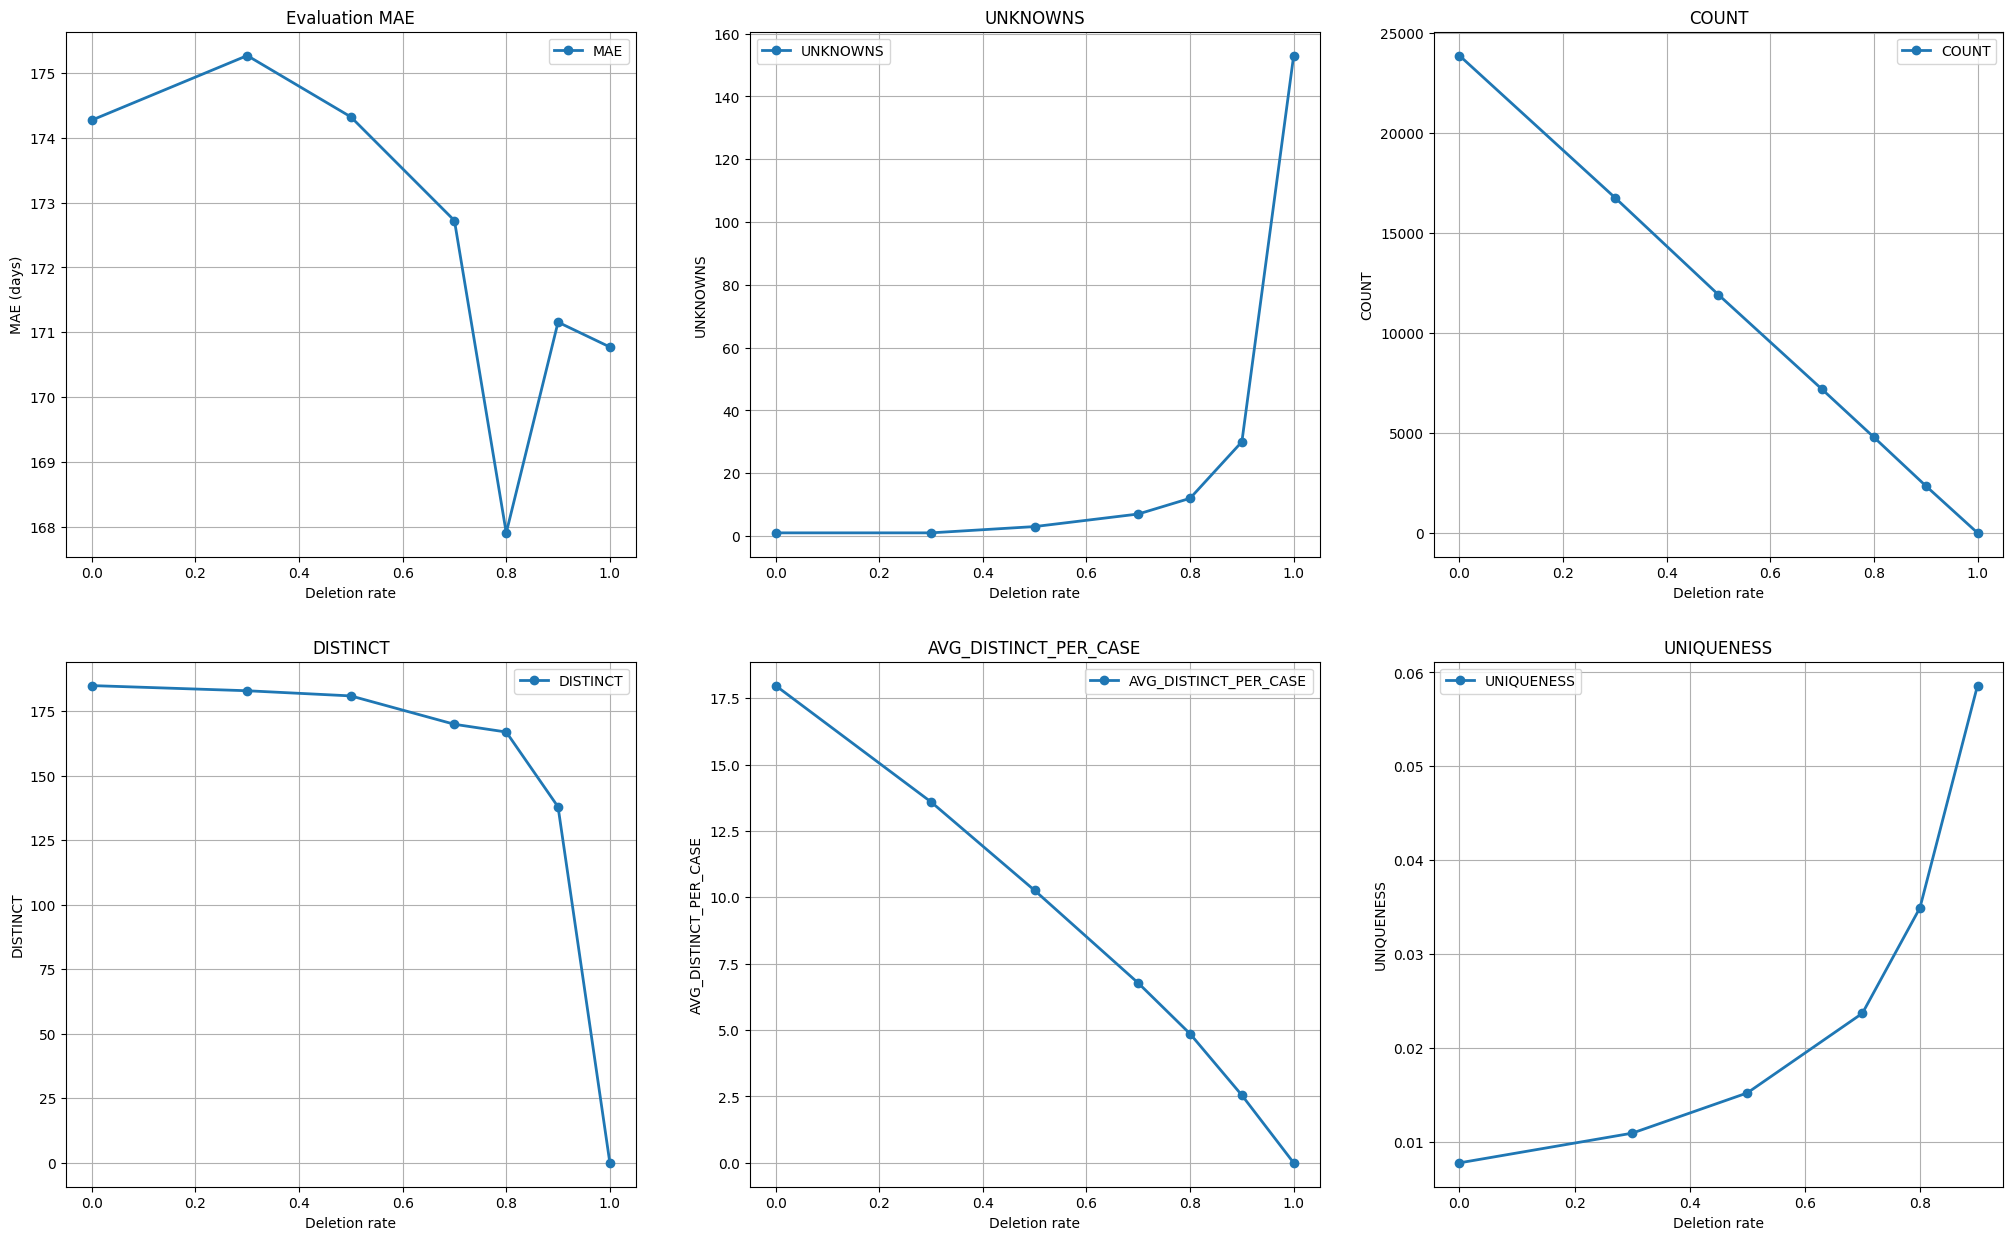

In [ ]:
make_graphs(dataset)

# BPIC15

In [ ]:
dataset = "BPIC15_1_f2"

In [ ]:
#activitiesVSmae(dataset)

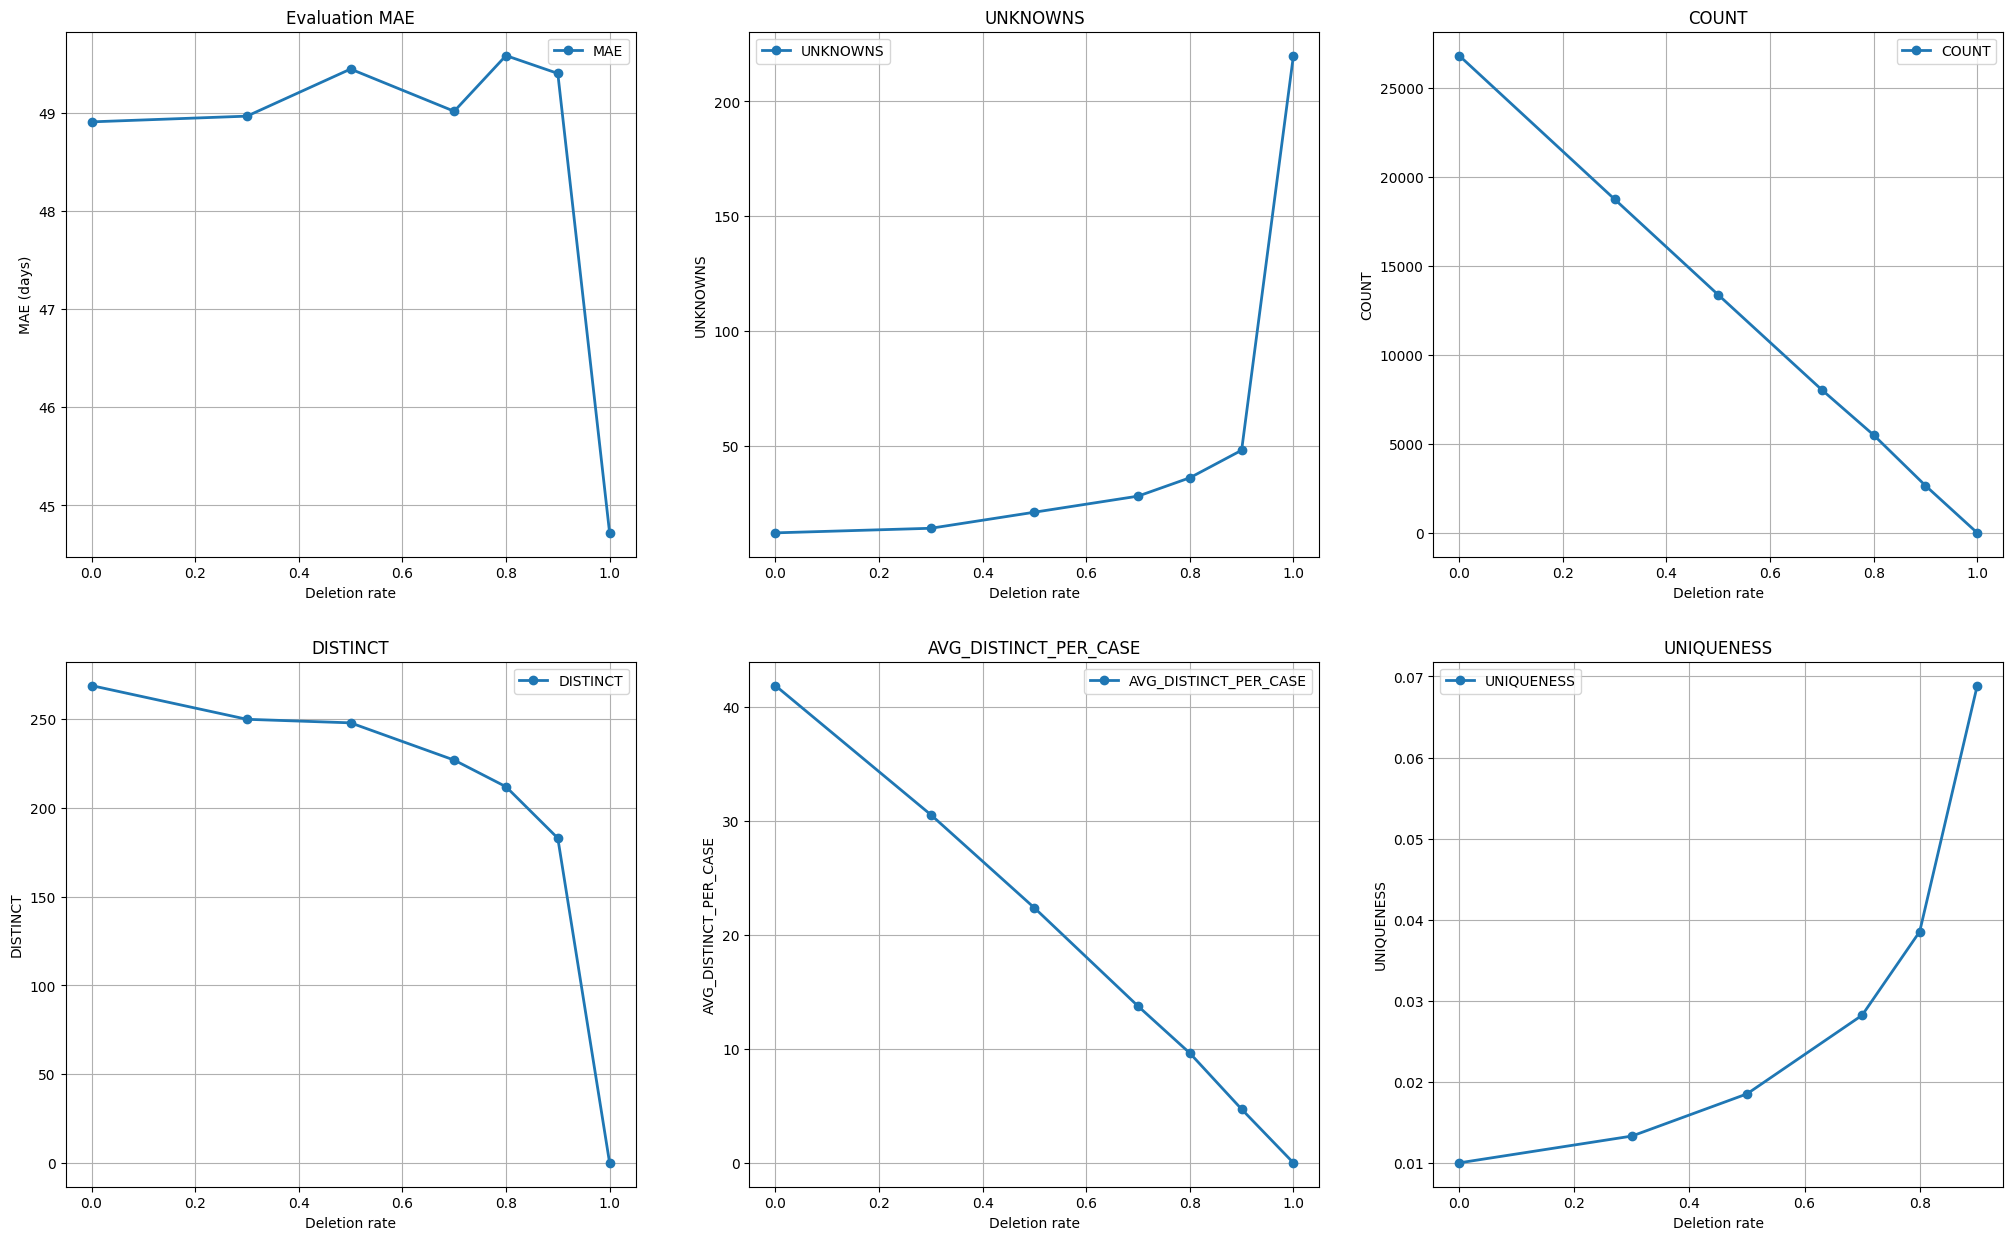

In [ ]:
make_graphs(dataset)

#Credit

In [ ]:
dataset = "Credit"

In [ ]:
#activitiesVSmae(dataset)

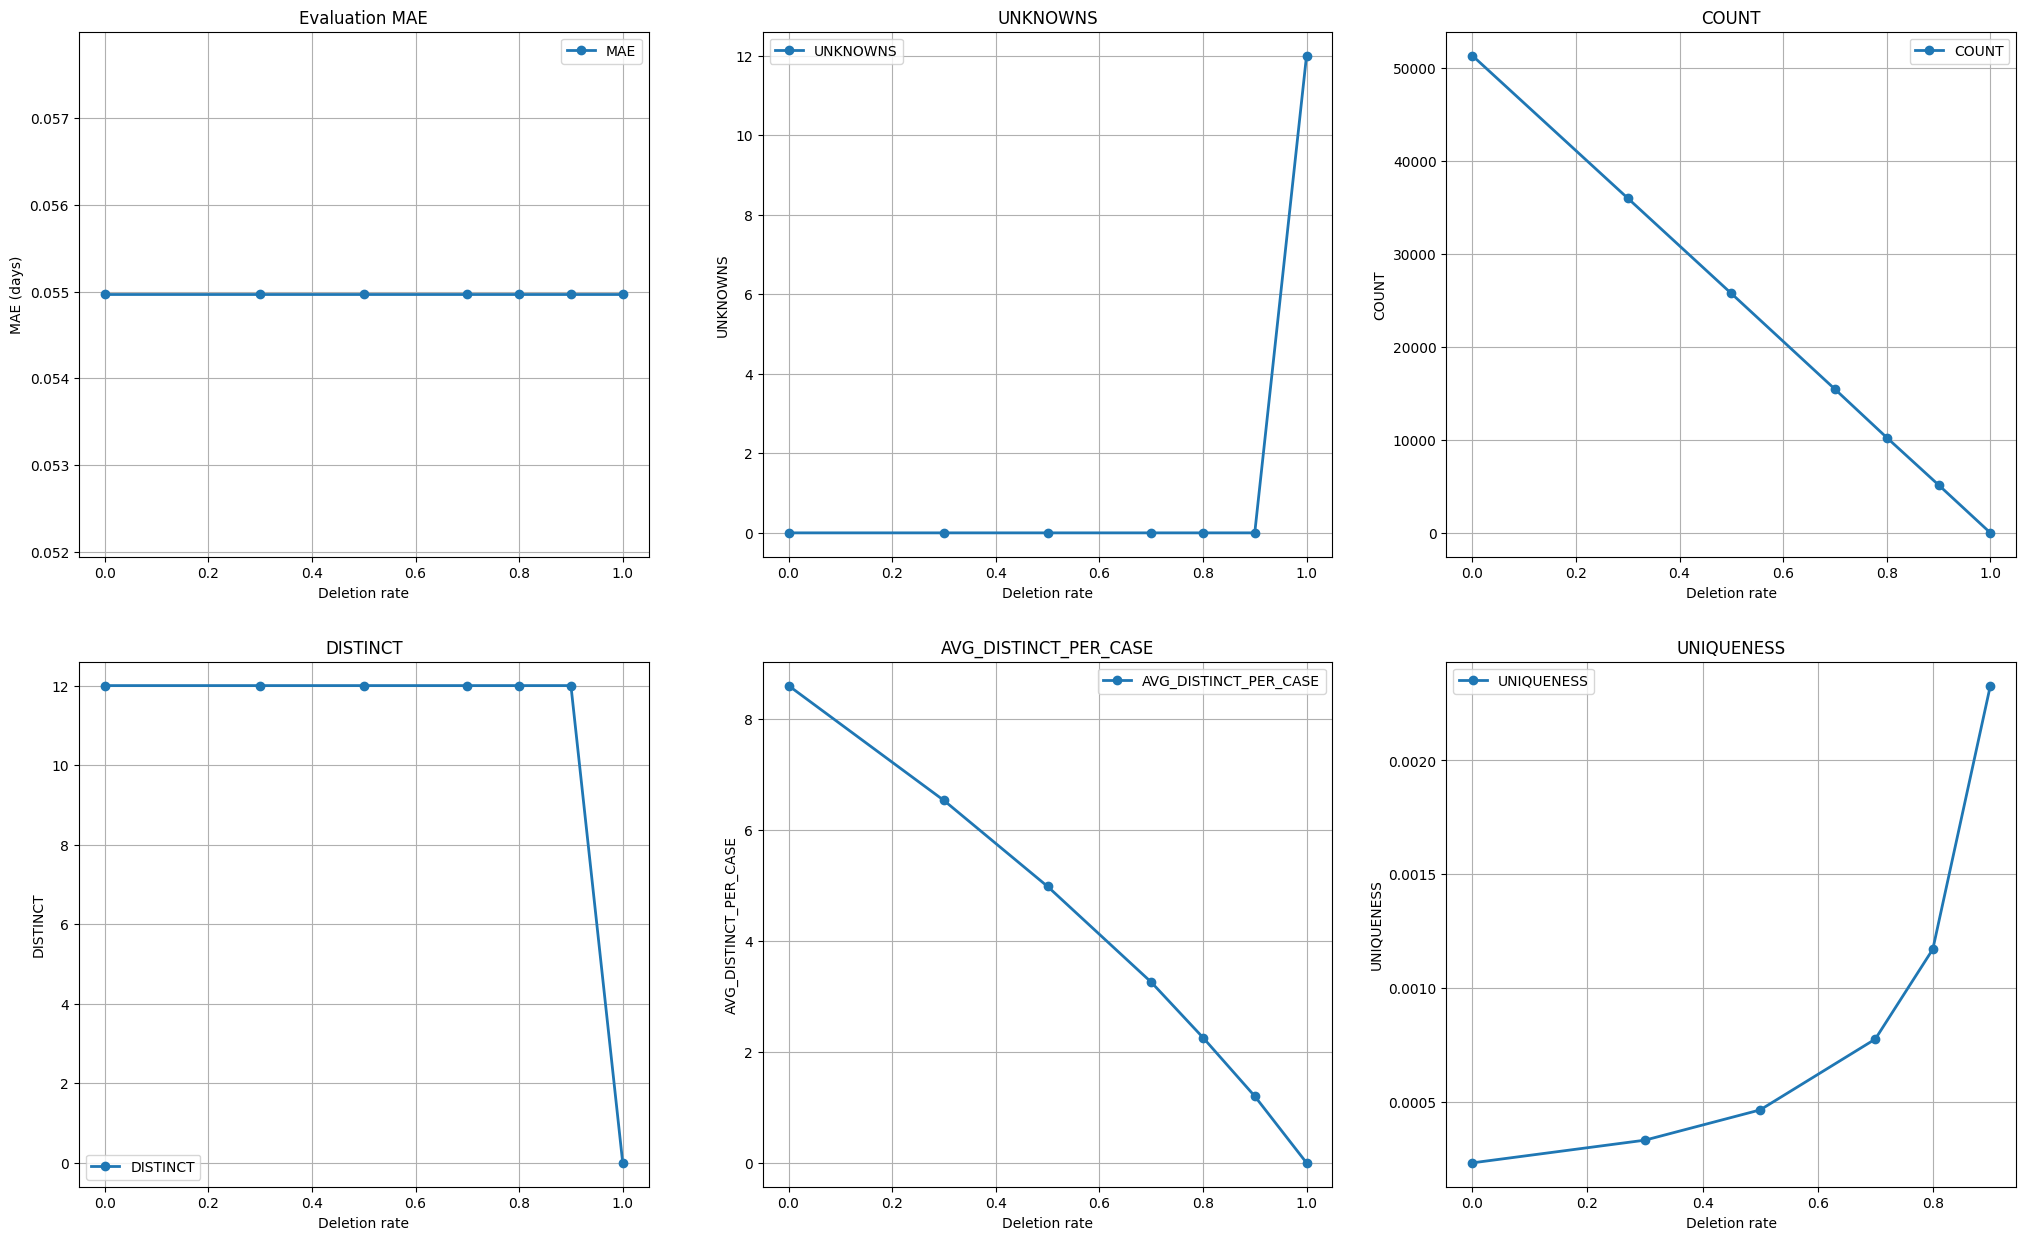

In [ ]:
make_graphs(dataset)

#Pub

In [ ]:
dataset = "Pub"

In [ ]:
#activitiesVSmae(dataset)

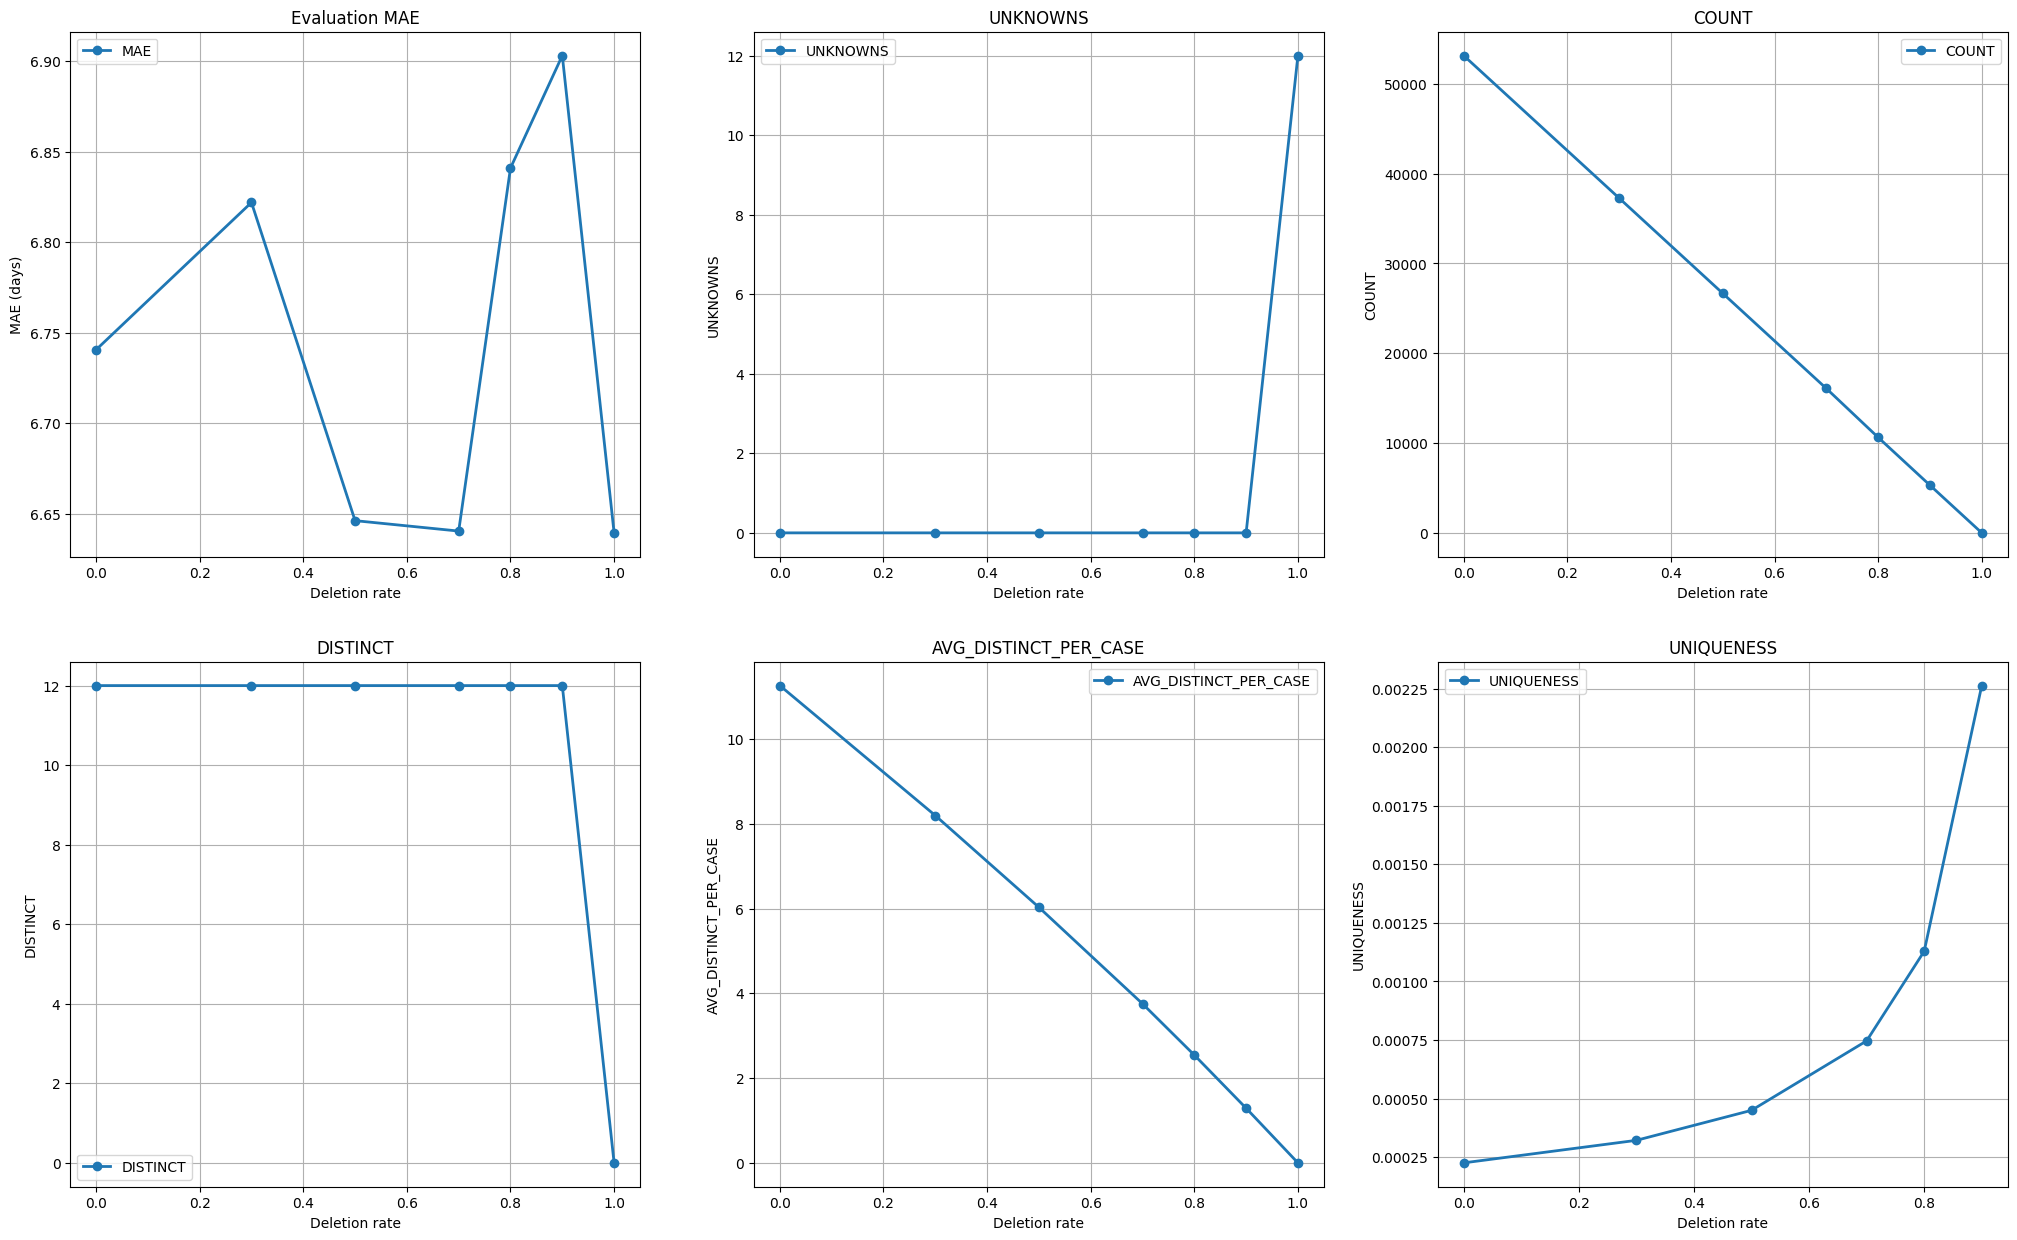

In [ ]:
make_graphs(dataset)

#BPIC12

In [ ]:
dataset = "BPIC12"

In [ ]:
#activitiesVSmae(dataset)

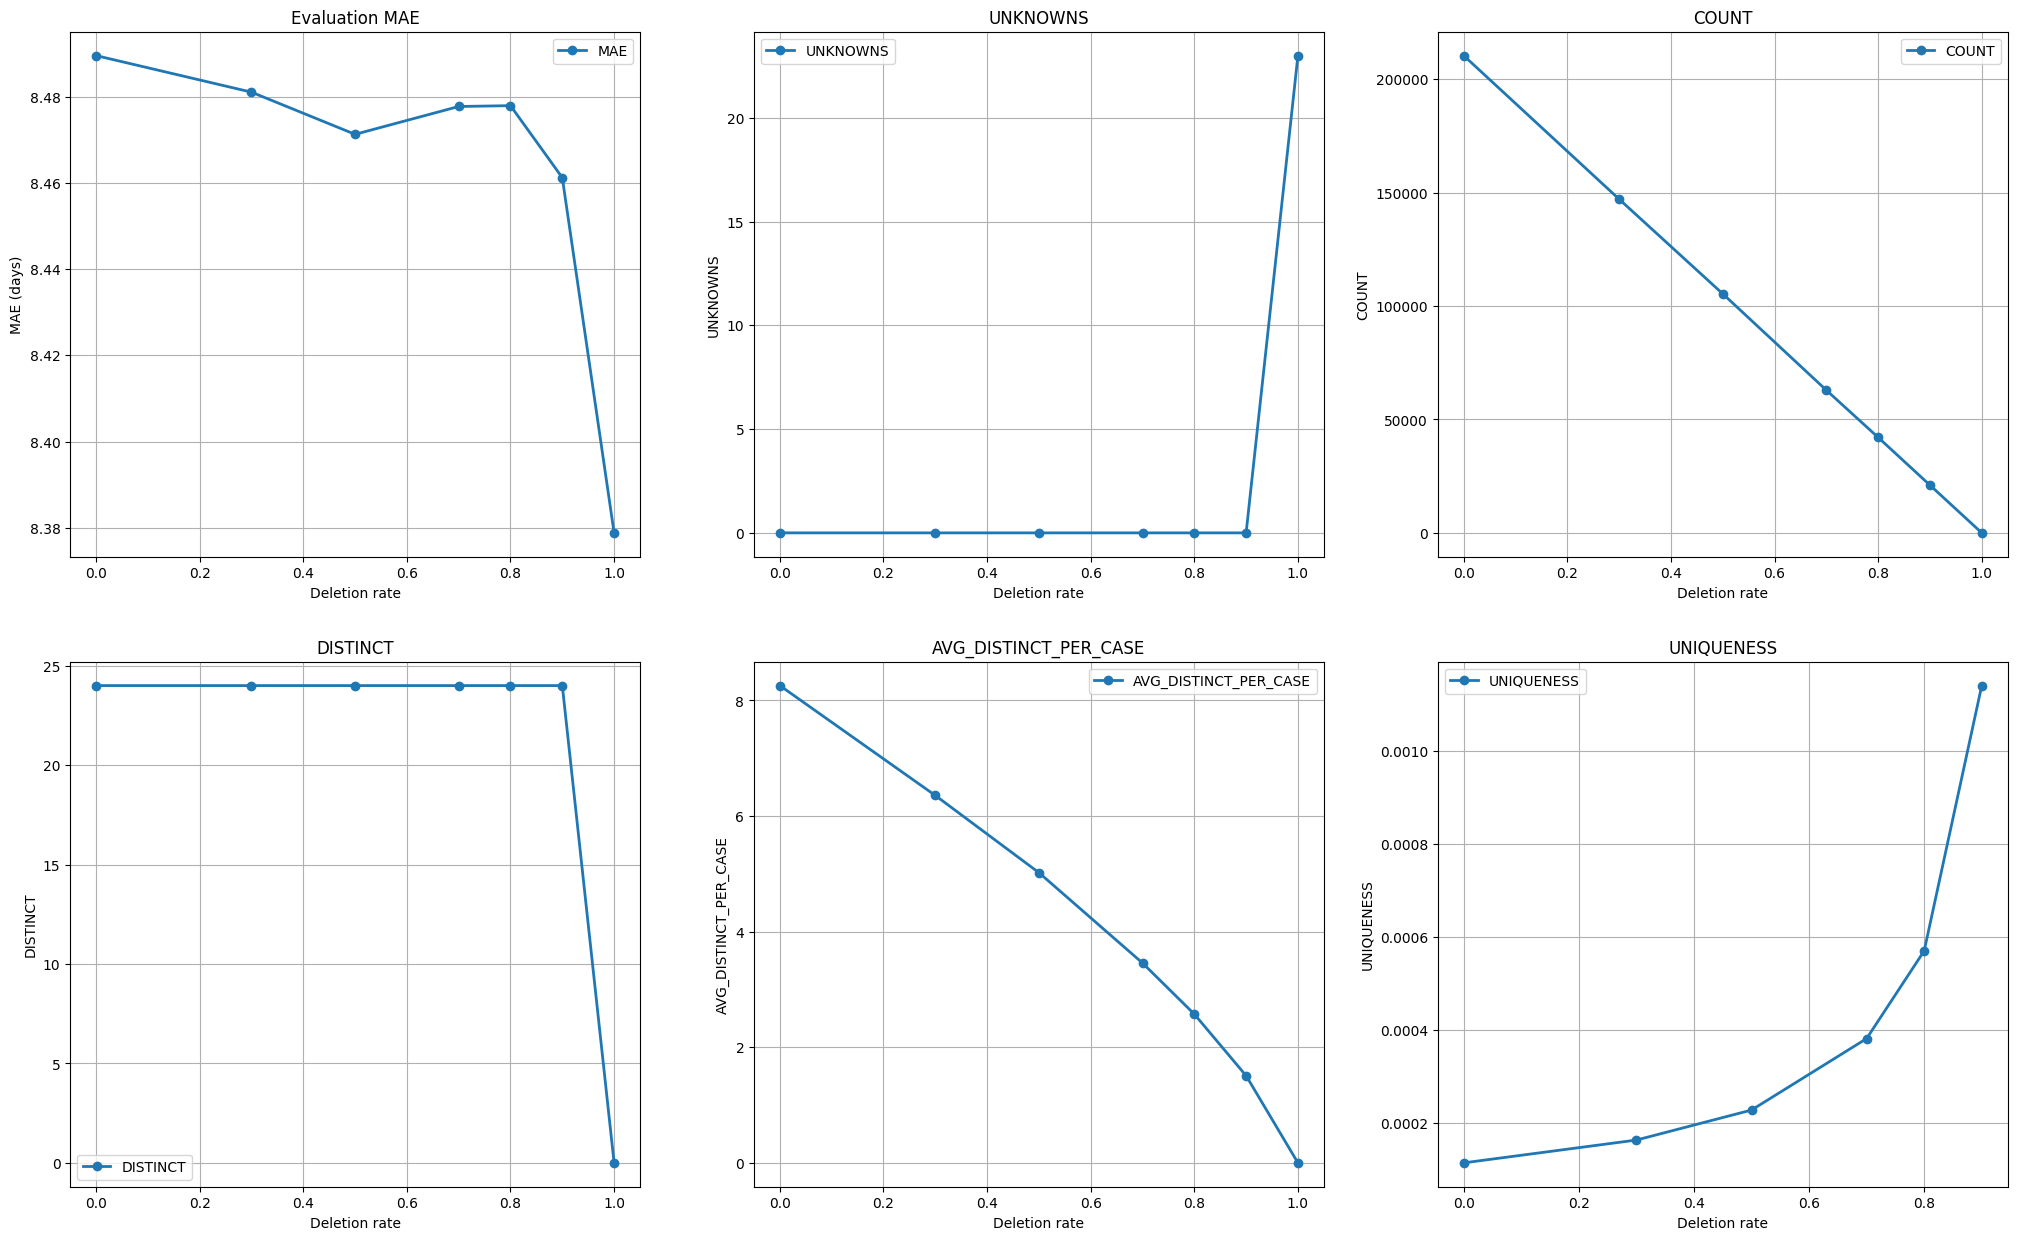

In [ ]:
make_graphs(dataset)

#BPIC17

In [ ]:
dataset = "BPIC17"

In [ ]:
#activitiesVSmae(dataset)

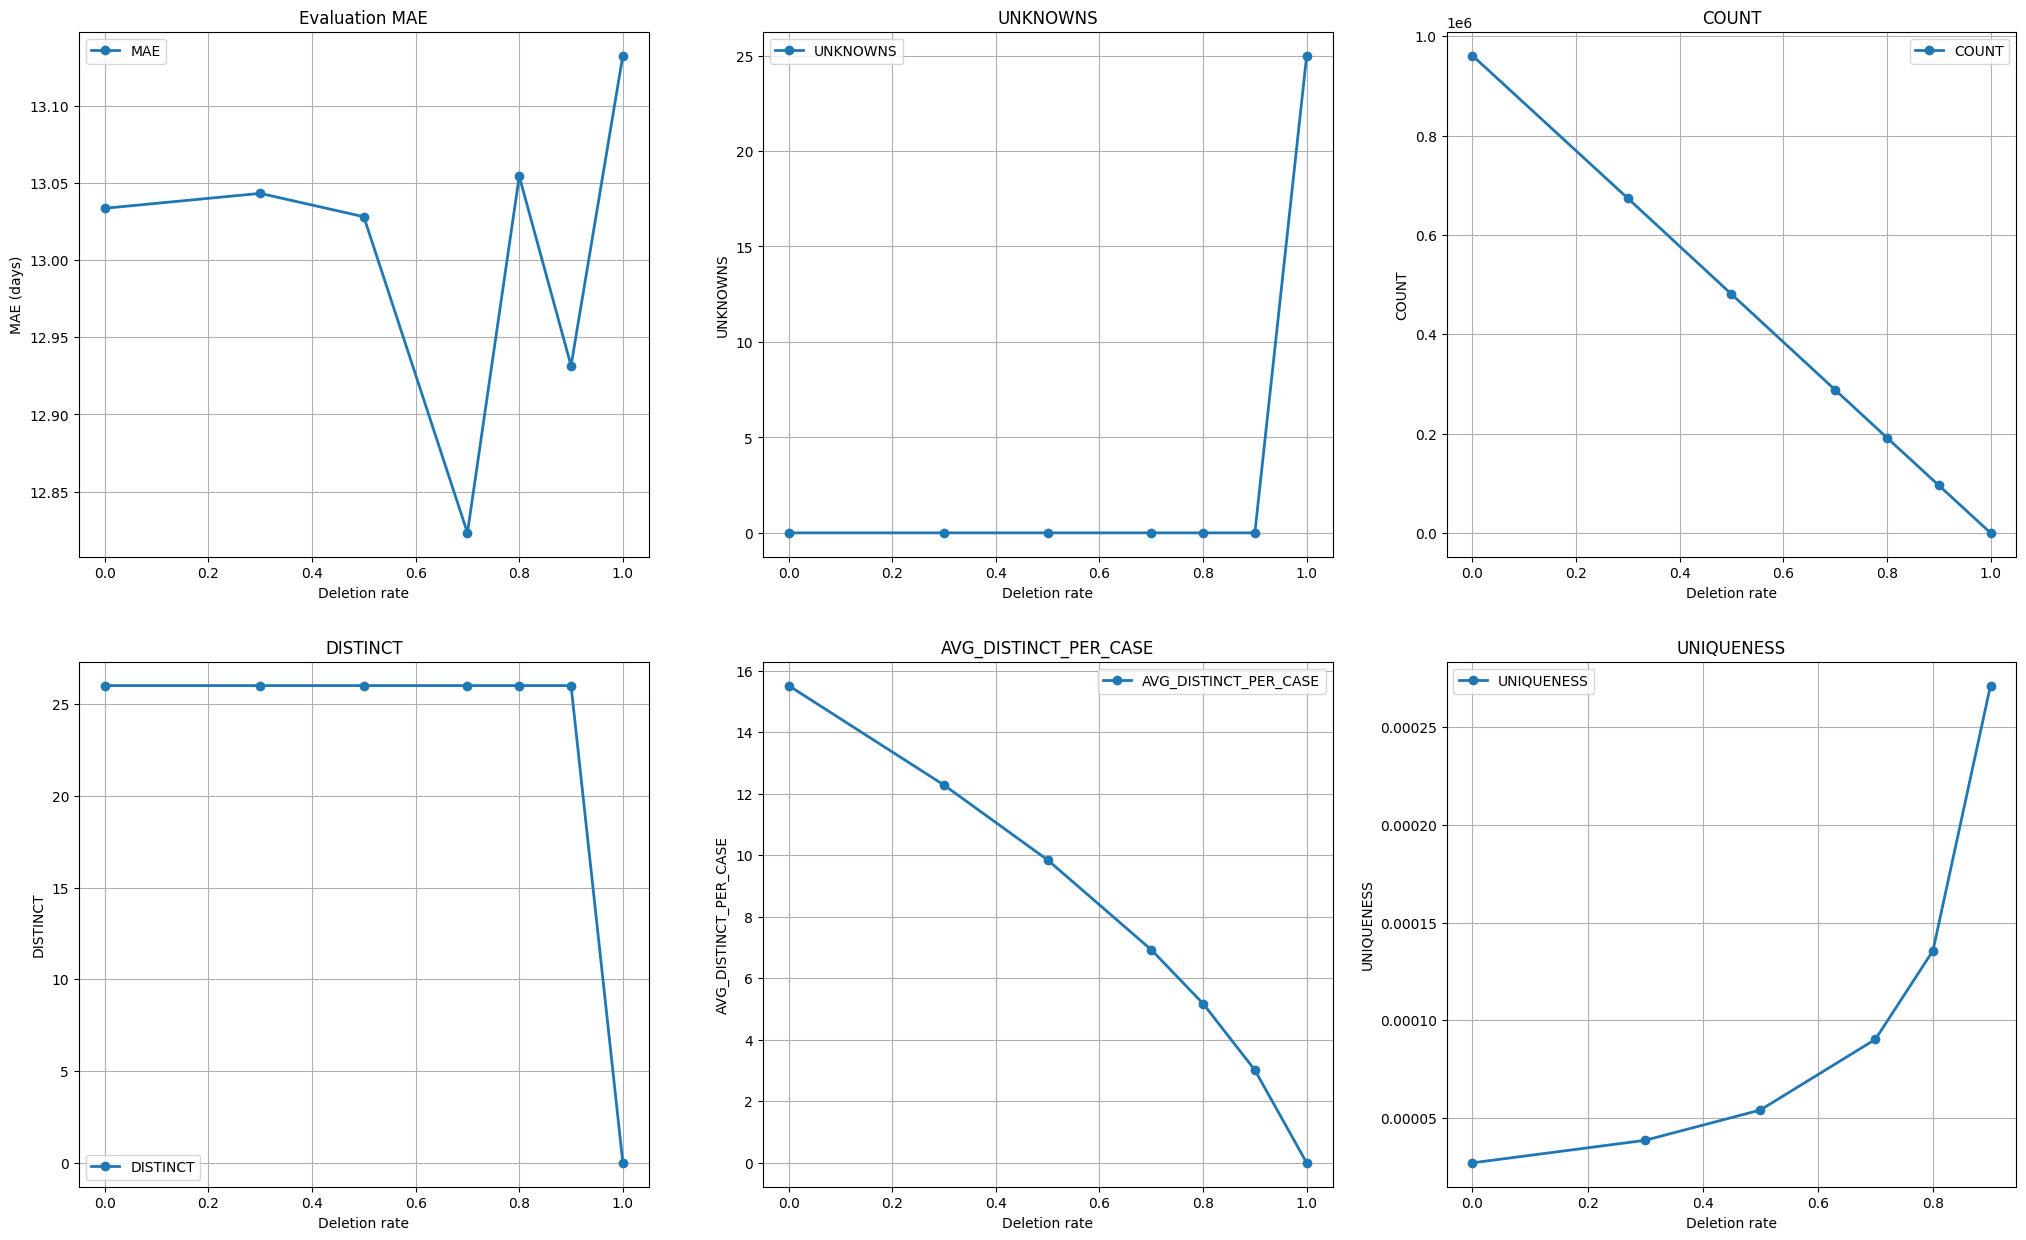

In [ ]:
make_graphs(dataset)

#BPIC20

In [ ]:
dataset = "BPIC20"

## DomesticDeclarations

In [ ]:
subset = "DomesticDeclarations"

In [ ]:
#activitiesVSmae(dataset, subset)

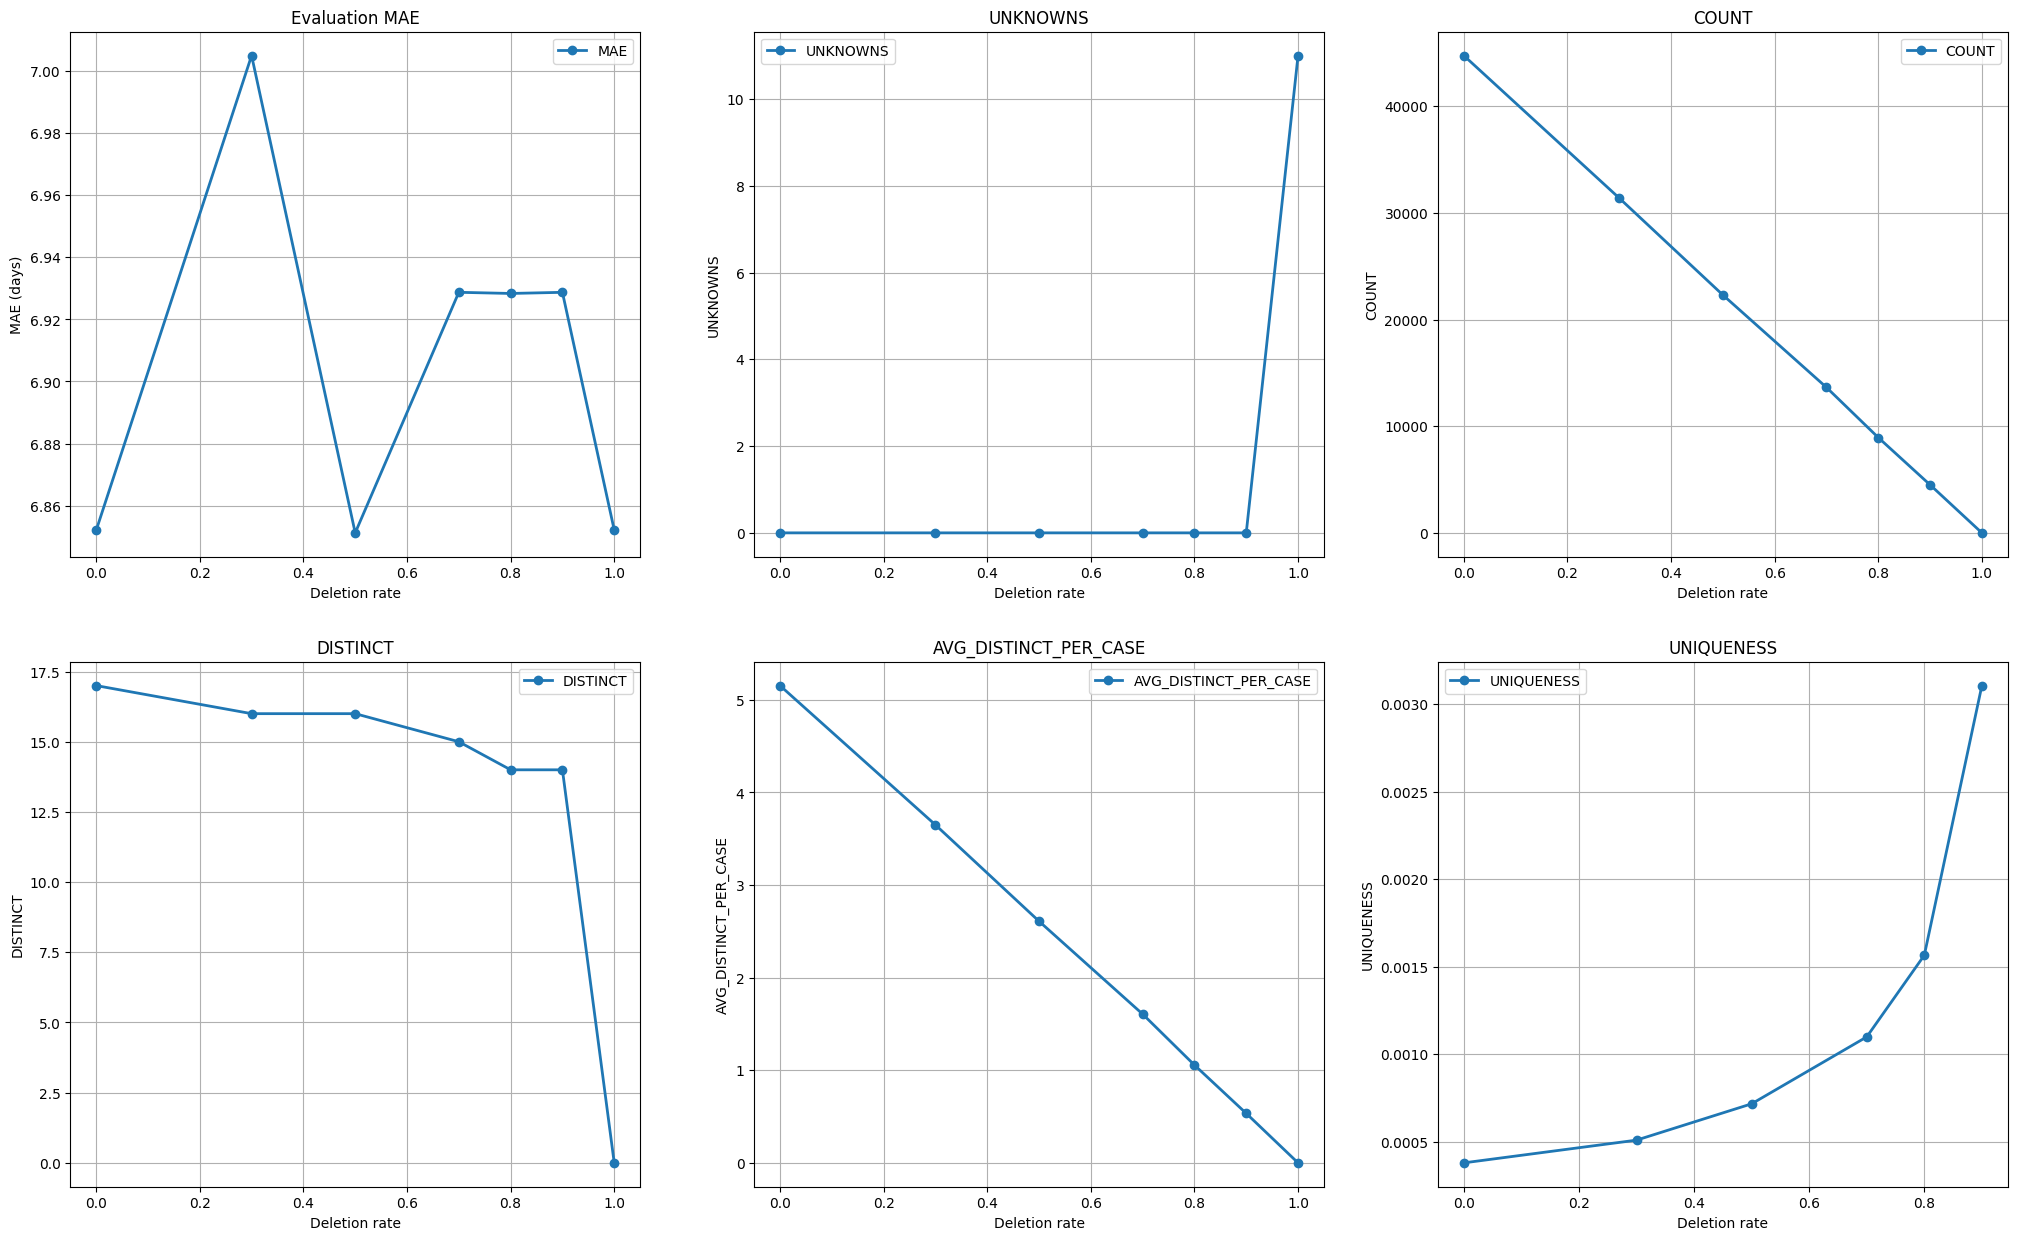

In [ ]:
make_graphs(dataset, subset)

## InternationalDeclarations

In [ ]:
subset = "InternationalDeclarations"

In [ ]:
#activitiesVSmae(dataset, subset)

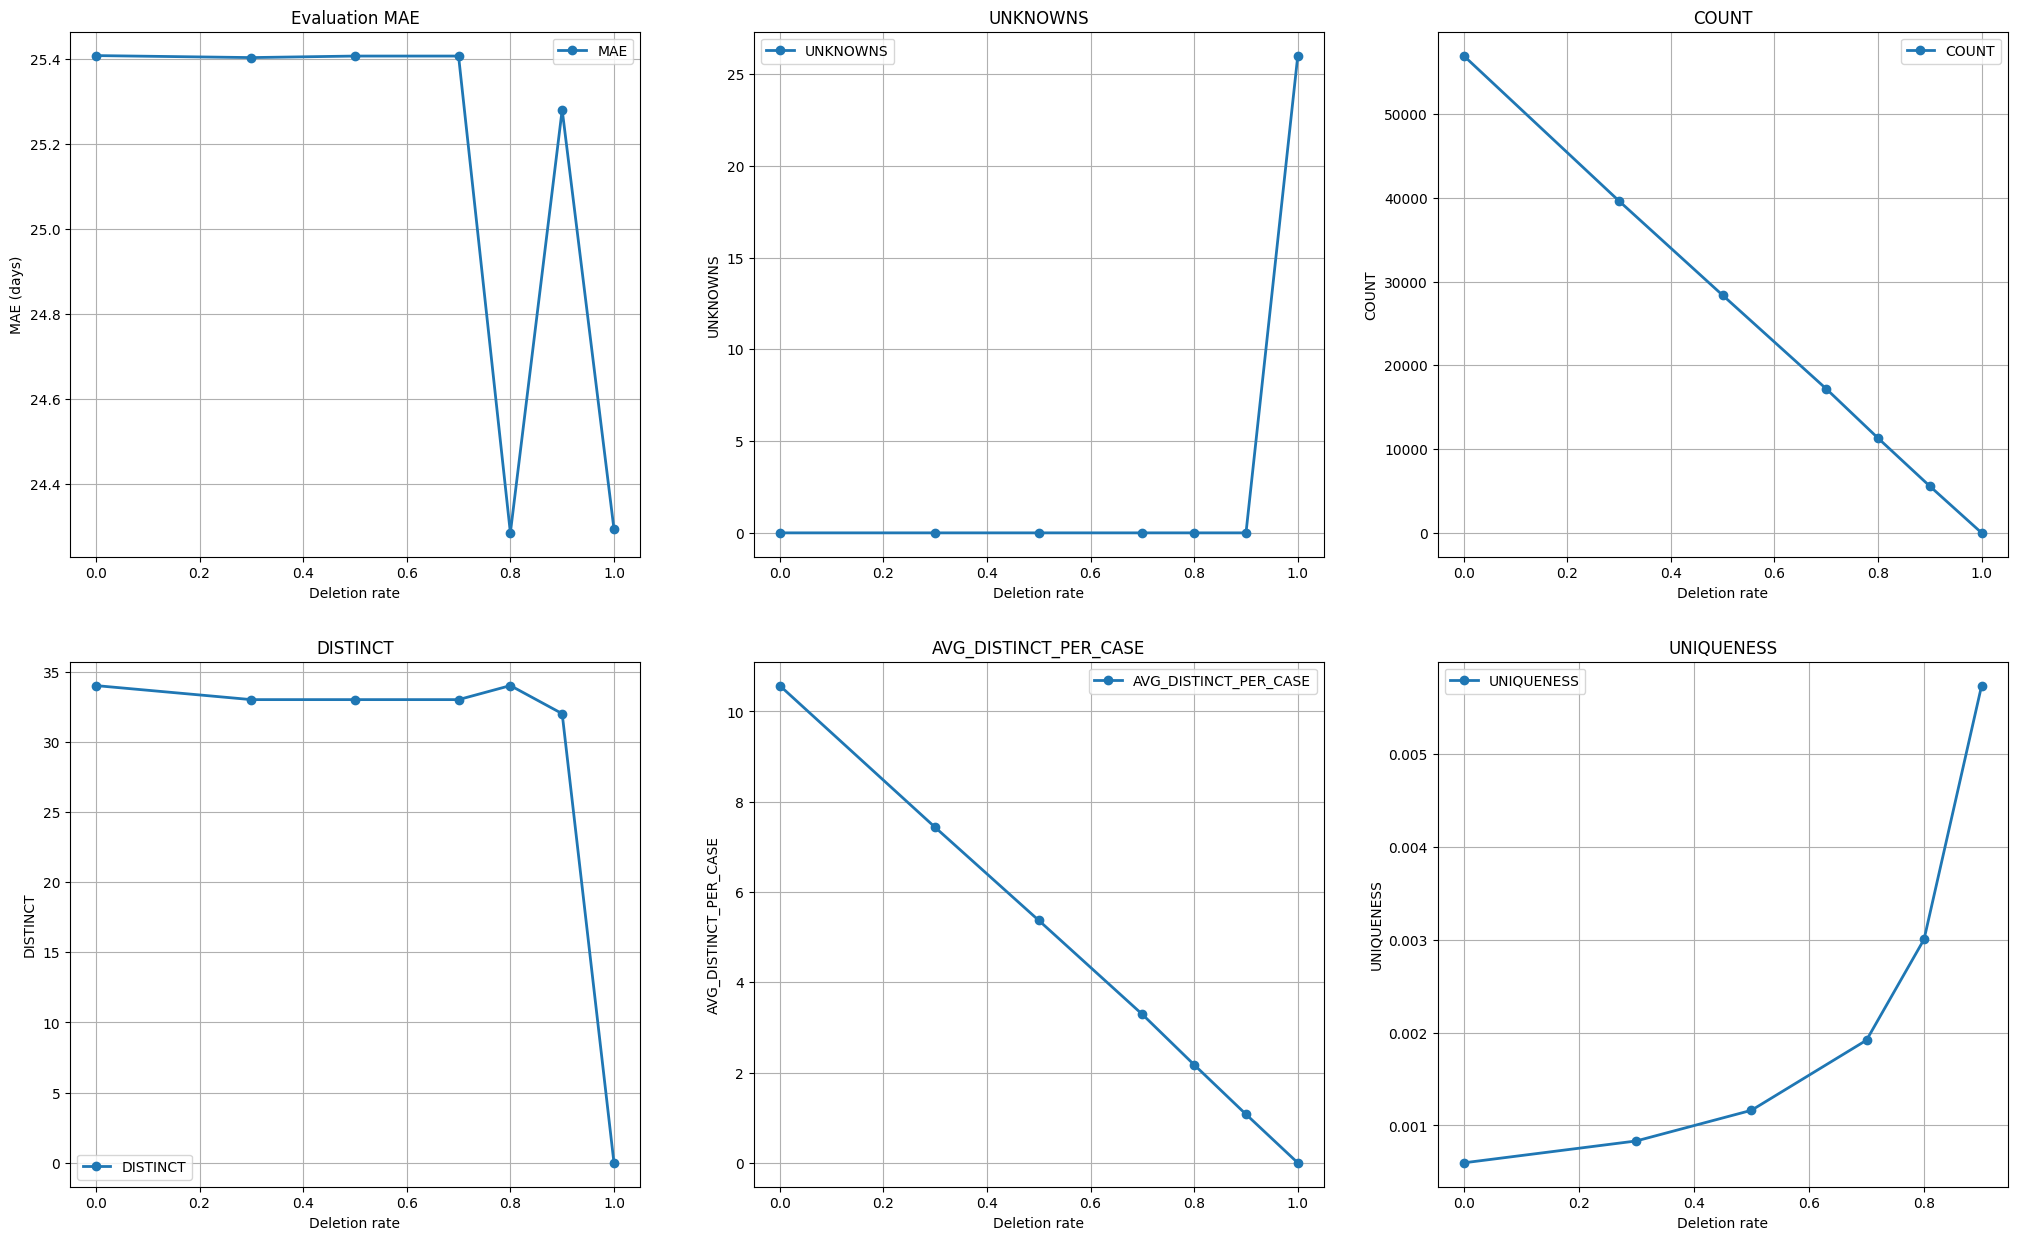

In [ ]:
make_graphs(dataset, subset)

## PermitLog

In [ ]:
subset = "PermitLog"

In [ ]:
#activitiesVSmae(dataset, subset)

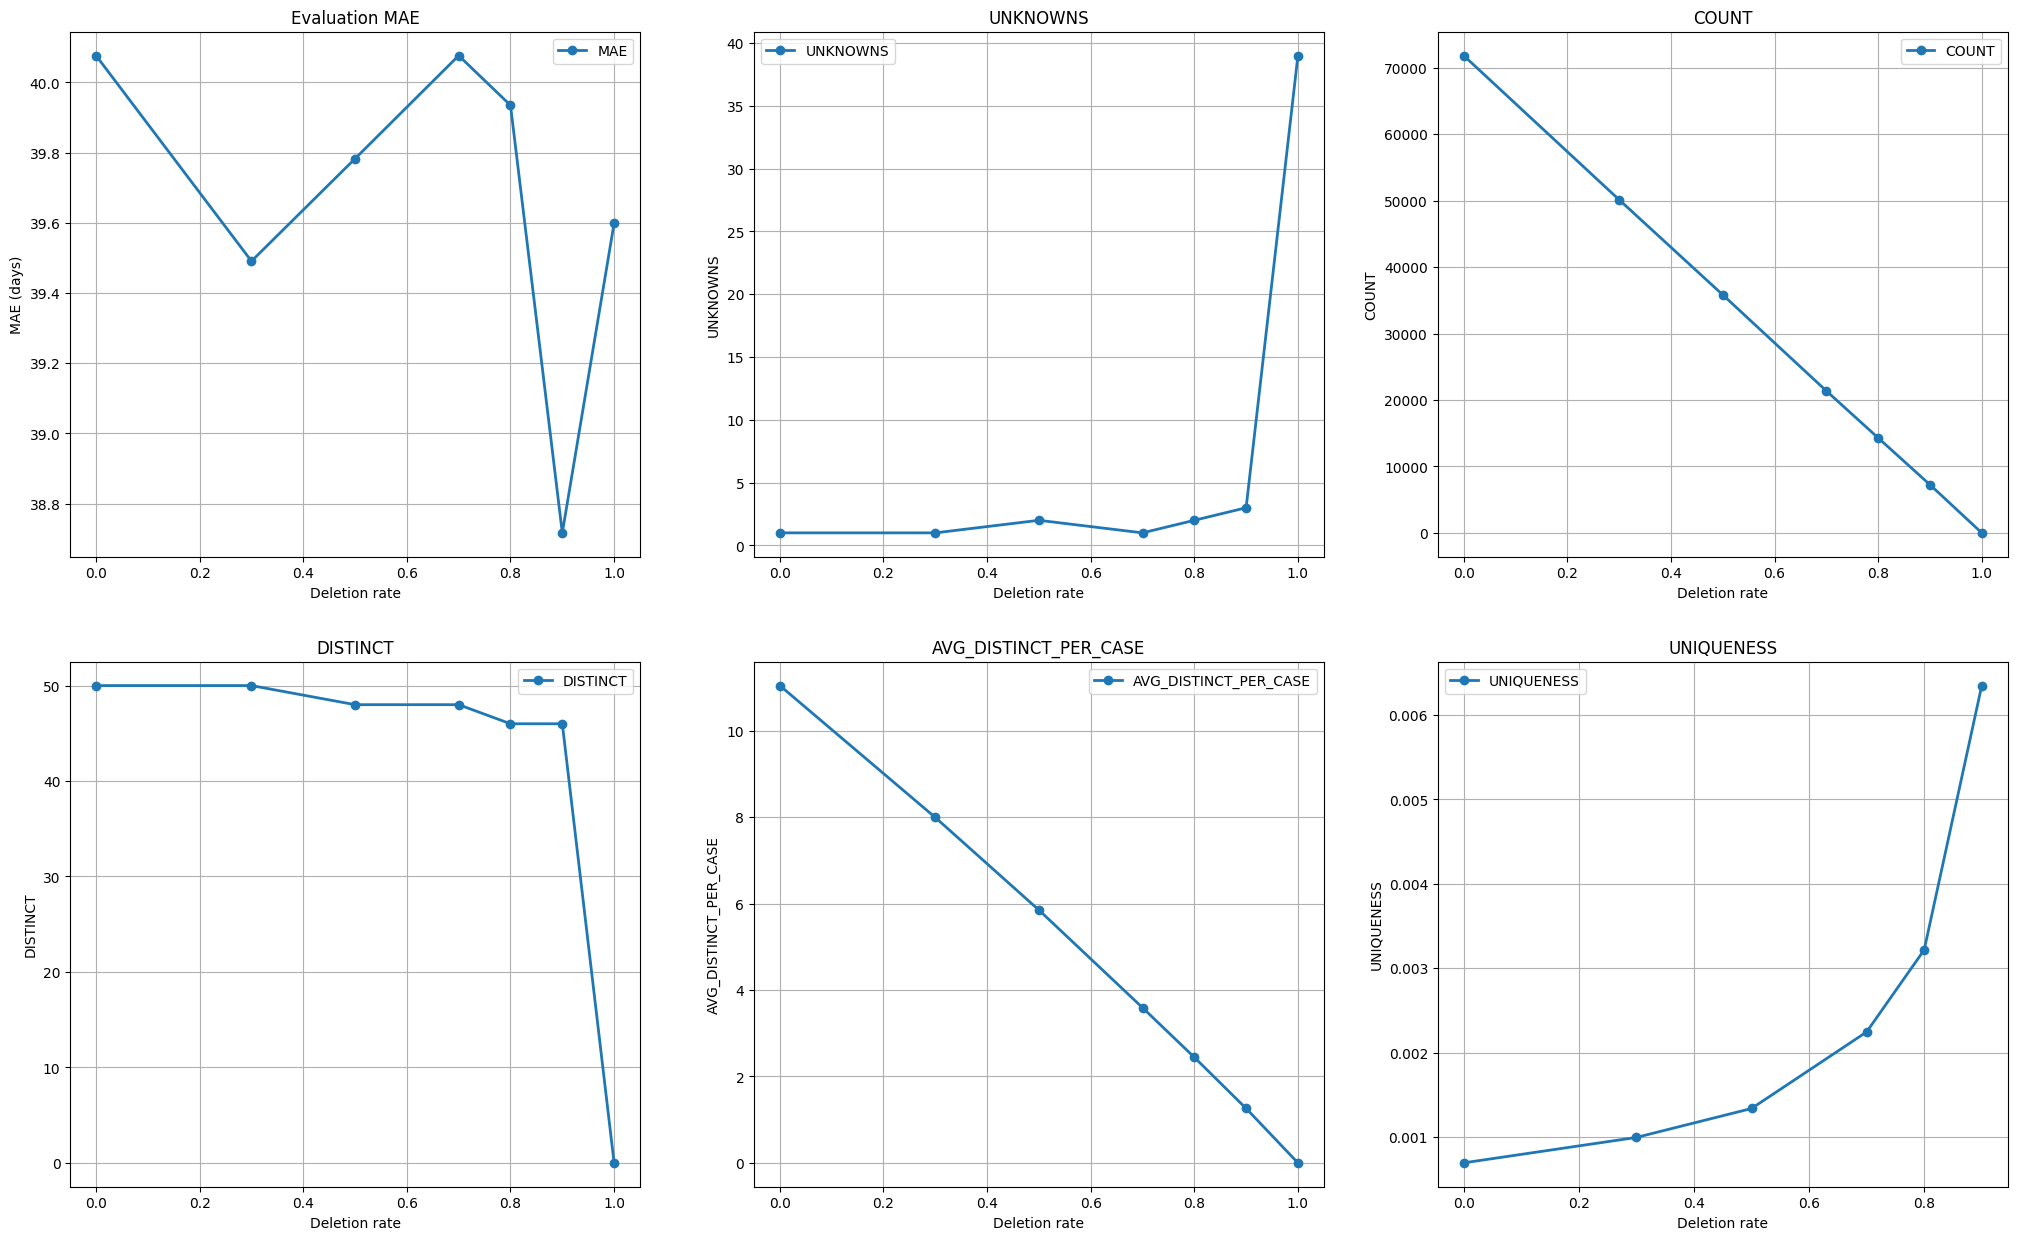

In [ ]:
make_graphs(dataset, subset)

## PrepaidTravelCost

In [ ]:
subset = "PrepaidTravelCost"

In [ ]:
#activitiesVSmae(dataset, subset)

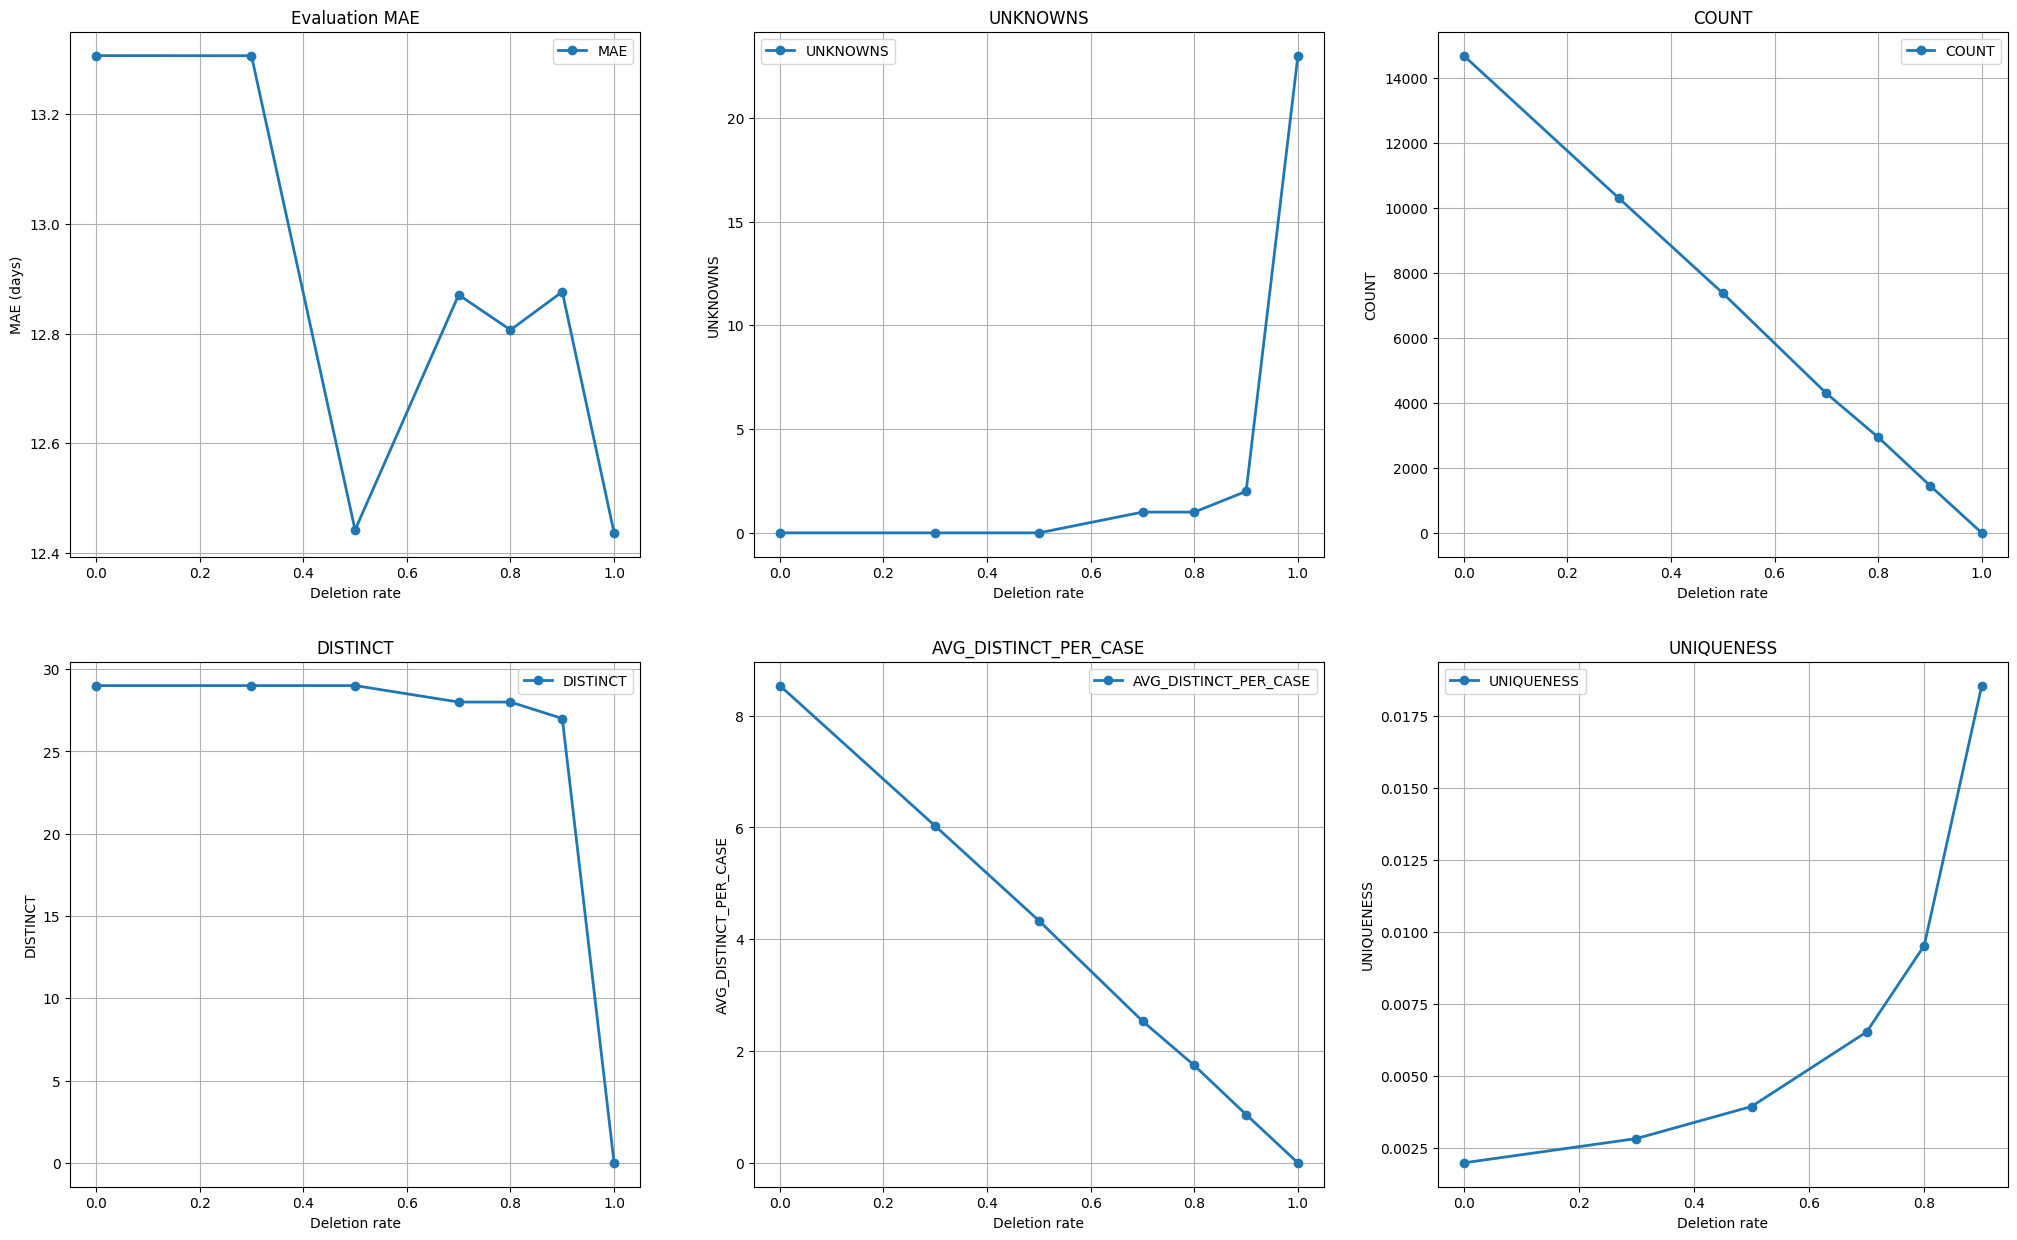

In [ ]:
make_graphs(dataset, subset)

## RequestForPayment

In [ ]:
subset = "RequestForPayment"

In [ ]:
#activitiesVSmae(dataset, subset)

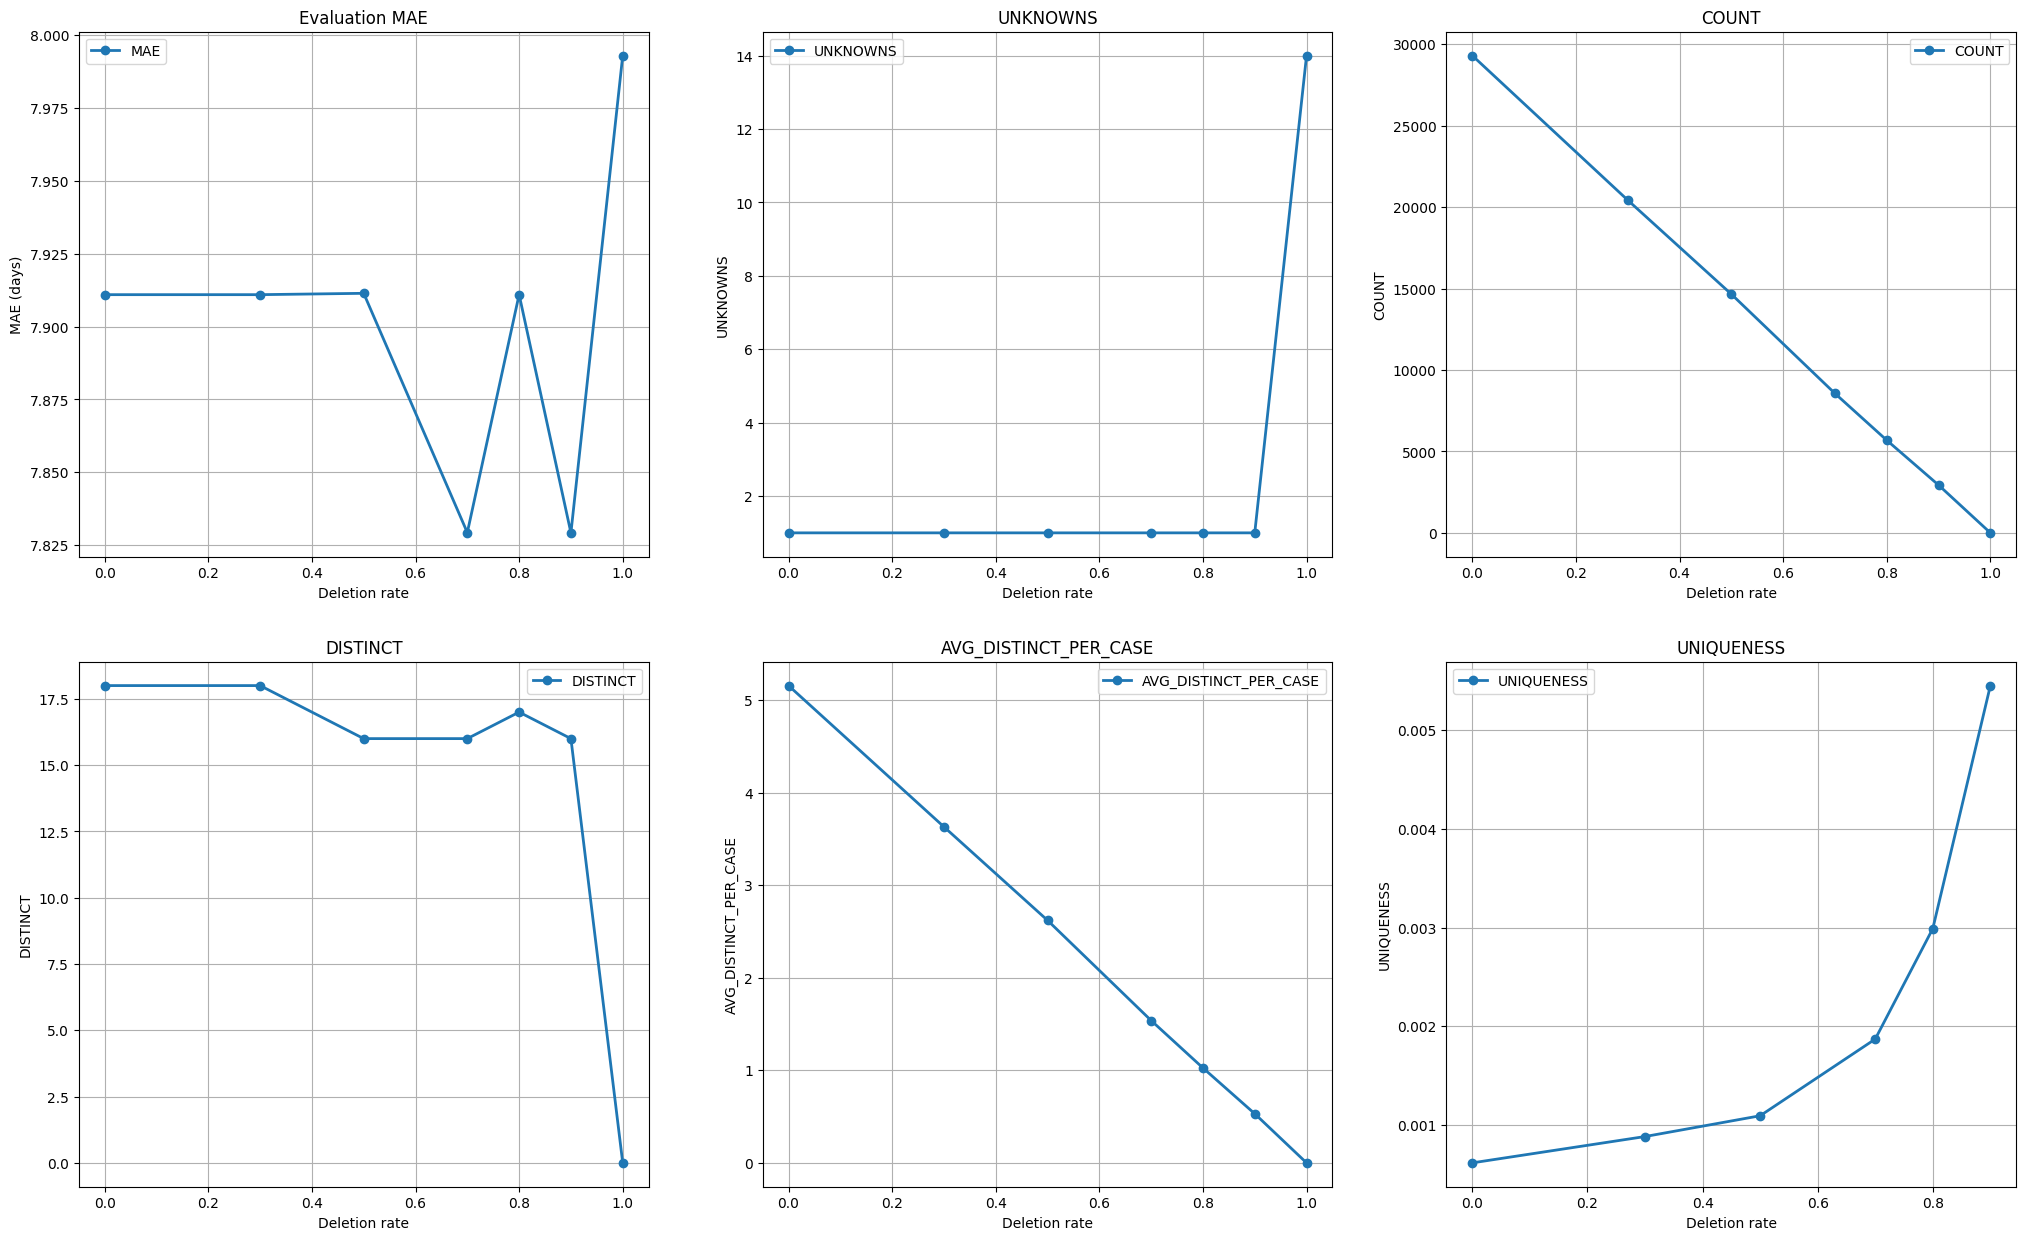

In [ ]:
make_graphs(dataset, subset)